In [2]:
%load_ext autoreload
%autoreload 2

# Standard imports
import sys
sys.path.append("../../")
import time
import gc

# 3rd party imports
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import nibabel as nib
import numpy as np 
import scipy 
import SimpleITK as sitk
from tqdm import tqdm 

# Our libraries
import laplacian 
import correspondences
import jacobian

Jacobian functions

In [3]:
def test_det(up_coord, bottom_coord, left_coord, right_coord, debug=False):
    """
    Compute the Jacobian determinant at a specific point in the deformation field.
    
    Parameters:
    - deformation: The deformation field (3D vector field).
    - coord: The coordinates of the point (z, y, x).
    
    Returns:
    - det: The Jacobian determinant at the specified point.
    """
    #print(coord)
    
    # Compute the partial derivatives
    dFx_dx = (right_coord[0] - left_coord[0]) / 2
    dFx_dy = (up_coord[0] - bottom_coord[0]) / 2
    #print(dFx_dx, dFx_dy, dFx_dz)
    #print(deformation[2, z, y, x + 1], "-", deformation[2, z, y, x - 1])

    dFy_dx = (right_coord[1] - left_coord[1]) / 2
    dFy_dy = (up_coord[1] - bottom_coord[1]) / 2


    # Form the Jacobian matrix
    # Note that the determinant of a zero vector field is also zero, whereas the Jacobian determinant of the corresponding identity warp transformation is 1.0. 
    # In order to compute the effective deformation Jacobian determinant 1.0 must be added to the diagonal elements of Jacobian prior to taking the derivative. 
    # i.e. det([ (1.0+dx/dx) dx/dy dx/dz ; dy/dx (1.0+dy/dy) dy/dz; dz/dx dz/dy (1.0+dz/dz) ])
    jacobian_matrix = np.array([
        [dFx_dx + 1, dFx_dy],
        [dFy_dx, dFy_dy + 1]
    ])
    
    if debug:
        print("(dFx/dx + 1) * (dFy/dy + 1) - (dFx/dy) * (dFy/dx)")
        print("\t" + str(dFx_dx + 1) + " * " + str(dFy_dy + 1) + " - " + str(dFx_dy) + " * " + str(dFy_dx))
        print("\t" + str((dFx_dx + 1) * (dFy_dy + 1)) + " - " + str(dFx_dy * dFy_dx))
        print("\t" + str((dFx_dx + 1) * (dFy_dy + 1) - dFx_dy * dFy_dx))
        print("Jacobian")
        print(jacobian_matrix)

    # Compute the determinant of the Jacobian matrix
    det = np.linalg.det(jacobian_matrix)

    return det

up_vec = np.array([1, 2])
bottom_vec = np.array([2, 6])
left_vec = np.array([-6, 1])
right_vec = np.array([4, 3])
print(test_det(up_vec, bottom_vec, left_vec, right_vec, debug=True))

(dFx/dx + 1) * (dFy/dy + 1) - (dFx/dy) * (dFy/dx)
	6.0 * -1.0 - -0.5 * 1.0
	-6.0 - -0.5
	-5.5
Jacobian
[[ 6.  -0.5]
 [ 1.  -1. ]]
-5.499999999999999


Downsample example set of points

In [4]:
# Create sample set of points
mpoints_path = "data/corrected_correspondences_count_touching/mpoints.npy"
fpoints_path = "data/corrected_correspondences_count_touching/fpoints.npy"

mpoints, fpoints = correspondences.downsample_points(mpoints_path, fpoints_path, debug=False)

In [5]:
# Create a Laplacian matrix from the downsampled correspondence points
USE_ONE_IDX = False
# Select specific indices
if USE_ONE_IDX:
    curr_idx = 2
    curr_mpoints = mpoints[mpoints[:, 0] == curr_idx].copy()
    curr_fpoints = fpoints[fpoints[:, 0] == curr_idx].copy()
    curr_mpoints[:, 0] = 0
    curr_fpoints[:, 0] = 0
    print(curr_mpoints.shape)
    print(curr_fpoints.shape)
    fixed_sample = np.zeros((1, 20, 40))
else:
    # Use all indices
    curr_mpoints = mpoints.copy()
    curr_fpoints = fpoints.copy()
    fixed_sample = np.zeros((3, 20, 40))
deformation, A, Yd, Zd = laplacian.sliceToSlice3DLaplacian(fixed_sample, curr_mpoints, curr_fpoints)
print(deformation.shape)
print("Shape of A:", A.shape)
print("Rank of A:", np.linalg.matrix_rank(A.toarray()))

# Visualize the Jacobian determinants
jacobian_det = jacobian.sitk_jacobian_determinant(deformation)
print("Minimum Jacobian determinant:", np.min(jacobian_det))
print("Maximum Jacobian determinant:", np.max(jacobian_det))
print("Number of negative Jacobian determinants:", np.sum(jacobian_det < 0))
print("Number of zero Jacobian determinants:", np.sum(jacobian_det == 0))
print("Number of positive Jacobian determinants:", np.sum(jacobian_det > 0))
print("Jaocbian det shape:", jacobian_det.shape)
for i in range(jacobian_det.shape[0]):
    plt.figure(figsize=(10, 10))
    norm = mcolors.TwoSlopeNorm(vmin=min(jacobian_det.min(), -1), vcenter=0, vmax=jacobian_det.max())
    plt.imshow(jacobian_det[i], cmap='seismic')
    plt.title("Section " + str(i))
    plt.colorbar()
    
    curr_mpoints_slice = mpoints[mpoints[:, 0] == i][:, 1:]
    curr_fpoints_slice = fpoints[fpoints[:, 0] == i][:, 1:]

    plt.scatter(curr_mpoints_slice[:, 1], curr_mpoints_slice[:, 0], c='g')
    plt.scatter(curr_fpoints_slice[:, 1], curr_fpoints_slice[:, 0], c='r')
    
    for j in range(len(curr_mpoints_slice)):
        plt.annotate(
            '', 
            xy=(curr_fpoints_slice[j][1], curr_fpoints_slice[j][0]), 
            xytext=(curr_mpoints_slice[j][1], curr_mpoints_slice[j][0]), 
            arrowprops=dict(facecolor='black', shrink=0.045, headwidth=8, headlength=10, width=3)
        )
    
    #for j in range(len(curr_mpoints_slice)):
    #    plt.plot([curr_mpoints_slice[j][1], curr_fpoints_slice[j][1]], 
    #             [curr_mpoints_slice[j][0], curr_fpoints_slice[j][0]], color='blue', alpha=0.75)
    
    plt.show()


Loading fixed image
Loaded fixed image
fdata.shape (3, 20, 40)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.04660797119140625s
Computing dy
dy calculated in 0.05707502365112305s
Computing dx
dx calculated in 0.059975624084472656s


ValueError: too many values to unpack (expected 4)

Create some sample points of our own

Loading fixed image
Loaded fixed image
fdata.shape (1, 5, 5)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dy
dx calculated in 0.03133106231689453s
Computing dx
dz calculated in 0.032022953033447266s
A shape: (25, 25)
[[ 2. -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  3. -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  3. -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  3. -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0. -1.  4. -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0. 

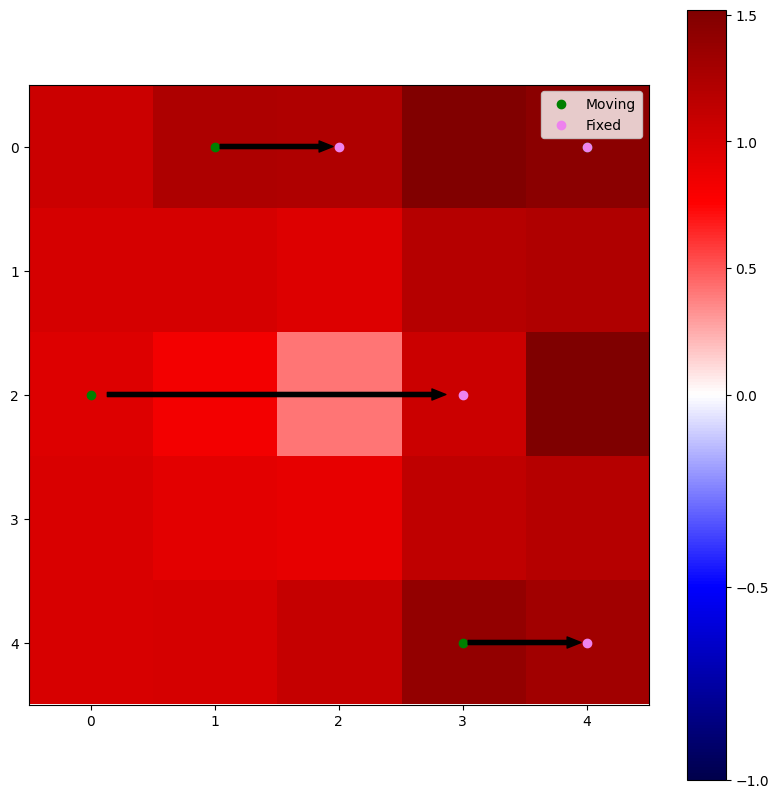

In [15]:
# Create some example correspondence points
"""
msample = np.array([
    [0, 0, 1],
    [0, 2, 0],
    [0, 3, 0],
    [0, 4, 4],
    [0, 4, 2],
    [0, 0, 4],
])
fsample = np.array([
    [0, 0, 2],
    [0, 1, 3],
    [0, 3, 1],
    [0, 4, 3],
    [0, 3, 2],
    [0, 0, 4],
])
"""

# Create some example correspondence points
msample = np.array([
    [0, 0, 1],
#    [0, 1, 0],
#    [0, 3, 0],
    [0, 4, 3],
 #   [0, 4, 2],
    [0, 0, 4],
    [0, 2, 0]
])
fsample = np.array([
    [0, 0, 2],
#    [0, 1, 3],
#    [0, 3, 1],
    [0, 4, 4],
#    [0, 3, 2],
    [0, 0, 4],
    [0, 2, 3]
])


"""
msample = np.array([
    [0, 0, 1],
    [0, 2, 0],
    [0, 3, 0],
    [0, 4, 4],
    [0, 4, 2],
    [0, 0, 4],
    [0, 3, 3],
])
fsample = np.array([
    [0, 0, 2],
    [0, 1, 3],
    [0, 3, 1],
    [0, 4, 3],
    [0, 3, 2],
    [0, 0, 4],
    [0, 1, 1]
])
"""

# Visualize the points
"""
plt.figure(figsize=(10, 10))
plt.scatter(msample[:, 2], msample[:, 1], c='g')
plt.scatter(fsample[:, 2], fsample[:, 1], c='r')
for i in range(len(msample)):
    plt.plot([msample[i][2], fsample[i][2]], [msample[i][1], fsample[i][1]], color='blue', alpha=0.75)
plt.gca().invert_yaxis()
plt.show()
"""

# Create a Laplacian matrix from a sample set of correspondence points
fixed_sample = np.zeros((1, 5, 5))
deformation, A, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)

# Visualize values
np.set_printoptions(linewidth=1000)
print("A shape:", A.shape)
print(A.toarray())
print("Rank of A:", np.linalg.matrix_rank(A.toarray()))
print("Yd shape:", Yd.shape)
print(Yd)
print("Xd shape:", Xd.shape)
print(Xd)
print("Deformation shape:", deformation.shape)
print("Deformation:")
print(deformation)
print()

# Calculate the Jacobian determinant
jacobian_det = jacobian.sitk_jacobian_determinant(deformation)
print("Minimum Jacobian determinant:", np.min(jacobian_det))
print("Maximum Jacobian determinant:", np.max(jacobian_det))
print("Number of negative Jacobian determinants:", np.sum(jacobian_det < 0))
print("Number of zero Jacobian determinants:", np.sum(jacobian_det == 0))
print("Number of positive Jacobian determinants:", np.sum(jacobian_det > 0))

# Create a custom colormap with white at zero
norm = mcolors.TwoSlopeNorm(vmin=min(jacobian_det.min(), -1), vcenter=0, vmax=jacobian_det.max())


plt.figure(figsize=(10, 10))
#plt.imshow(jacobian_det[0], cmap='seismic')
plt.imshow(jacobian_det[0], cmap='seismic', norm=norm, interpolation='nearest')
plt.colorbar()

for i in range(len(msample)):  # Draw lines connecting the points
    #plt.plot([msample[i][2], fsample[i][2]], [msample[i][1], fsample[i][1]], color='black', alpha=1)
    plt.annotate(
        '', 
        xy=(fsample[i][2], fsample[i][1]), 
        xytext=(msample[i][2], msample[i][1]), 
        arrowprops=dict(facecolor='black', shrink=0.045, headwidth=8, headlength=10, width=3)
    )
    
plt.scatter(msample[:, 2], msample[:, 1], c='g', label='Moving')
plt.scatter(fsample[:, 2], fsample[:, 1], c='violet', label='Fixed')
plt.legend()
plt.show()